# 项目：Zillow的房屋价值评估准确性预测

## 一、项目背景：
   比赛由kaggle举办，zillow使用公司内部的zestimator对房屋价值进行评估，评估结果与实际成交价格之间的误差以对数误差来显示。本项目要求选手利用2016年，2017年的数据集建立模型，并对所有房产在2016年10月、11月、12月及2017年10月、11月、12月时Zestimator的评估准确性进行预测。Zestimator的准确性由对数误差来表示，如下式：
   $$logerror=log(Zestimate)-log(SalePrice)$$
### 1.定义问题
   1. 影响Zestimator评估准确性最大的因素是什么？
   2. 建立模型预测给定时间点的对数误差。

### 2.数据集
   数据集包括2016年及2017年的房产信息及交易信息。

## 二、数据清洗及处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
#读取数据
train_data=pd.read_csv(r'E:\machine learning\zillow-prize-1\train_2016_v2.csv')
data_prop=pd.read_csv(r'E:\machine learning\zillow-prize-1\properties_2016.csv')

D:\software\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_data.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [4]:
data_prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


### 1.缺失值处理

In [5]:
#Check the missing data
def missing_data_table(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data_sketch=pd.concat([total,percent],axis=1,keys=['total','percent'])
    #Delete variables that don't have missing data
    missing_data=missing_data_sketch.loc[missing_data_sketch['total']!=0,:]
    
    print('number of features:{}；{} features have missing values'.format(missing_data_sketch.shape[0],missing_data.shape[0]))
    return missing_data

In [6]:
missing_data_table(train_data)

number of features:3；0 features have missing values


,total,percent


In [7]:
missing_data_table(data_prop)

number of features:58；57 features have missing values


,total,percent
storytypeid,2983593,0.999456
basementsqft,2983589,0.999455
yardbuildingsqft26,2982570,0.999113
fireplaceflag,2980054,0.998270
architecturalstyletypeid,2979156,0.997970
typeconstructiontypeid,2978470,0.997740
finishedsquarefeet13,2977545,0.997430
buildingclasstypeid,2972588,0.995769
decktypeid,2968121,0.994273
finishedsquarefeet6,2963216,0.992630


train_data没有缺失值，data_prop有好多缺失值，我们先将两表合并，然后再查看缺失值情况。

In [8]:
#merge the dataframes
train_data_merge=train_data.merge(data_prop,on='parcelid',how='left')

In [9]:
missing_data_table(train_data_merge)

number of features:60；47 features have missing values


,total,percent
buildingclasstypeid,90259,0.999823
finishedsquarefeet13,90242,0.999634
basementsqft,90232,0.999524
storytypeid,90232,0.999524
yardbuildingsqft26,90180,0.998948
fireplaceflag,90053,0.997541
architecturalstyletypeid,90014,0.997109
typeconstructiontypeid,89976,0.996688
finishedsquarefeet6,89854,0.995336
decktypeid,89617,0.992711


可以发现有60个特征中有47个特征存在缺失值，同时有很多特征的缺失度在80%以上。lightgbm会对缺失值进行处理，但考虑到缺失度太高的特征对预测没有帮助，故将缺失度在95%以上的特征删掉。

In [10]:
#track the columns
percent=train_data_merge.isnull().sum()/train_data_merge.isnull().count()
columns=[]
for key,perc in percent.items():
        if perc>0.95:
            columns.append(key)

#delete the variable
train_data_merge.drop(columns,axis=1,inplace=True)

In [11]:
train_data_merge.shape

(90275, 42)

### 2.探索异常值


In [12]:
train_data_merge.describe()

,parcelid,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,90275.000000,90275.000000,57364.000000,89093.000000,6856.000000,89614.000000,85596.000000,...,12009.000000,58353.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,2.279474,3.031869,5.565407,2.309216,1347.974037,1773.185987,1745.454531,...,1.008743,1.110414,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,6.049151e+13
std,2.504510e+06,0.161079,2.974168,1.004271,1.156436,1.900602,0.976172,652.399026,928.162393,909.941166,...,0.100830,0.797235,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,0.000000,0.000000,1.000000,1.000000,44.000000,2.000000,2.000000,...,1.000000,1.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,2.000000,2.000000,4.000000,2.000000,938.000000,1184.000000,1172.000000,...,1.000000,1.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,2.000000,3.000000,7.000000,2.000000,1244.000000,1540.000000,1518.000000,...,1.000000,1.000000,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,3.000000,4.000000,7.000000,3.000000,1614.000000,2095.000000,2056.000000,...,1.000000,1.000000,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,20.000000,16.000000,12.000000,20.000000,7625.000000,22741.000000,20013.000000,...,4.000000,143.000000,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,6.111009e+13


结合官方文档对各个特征的描述，没有发现异常值。

In [13]:
#结合官方文档，对columns名字进行修正，以方便理解及分析
train_data_merge=train_data_merge.rename(columns={'parcelid':'id_parcel',
                           'transactiondate':'date_transaction',
                           'transaction_month':'month_transaction',
                           'airconditioningtypeid':'aircon',
                           'bathroomcnt':'num_bathroom',
                           'bedroomcnt':'num_bedroom',
                           'buildingqualitytypeid':'quality',
                           'calculatedbathnbr':'num_bathroom_calc',
                           'calculatedfinishedsquarefeet':'area_total_calc',
                           'finishedsquarefeet12':'area_live_finished',
                           'fips':'fip',
                           'fullbathcnt':'num_bath',
                           'garagecarcnt':'num_garage',
                           'heatingorsystemtypeid':'heating',
                           'lotsizesquarefeet':'area_lot',
                           'propertycountylandusecode':'zoning_landuse_county',
                           'propertylandusetypeid':'zoning_landuse',
                           'propertyzoningdesc':'zoning_property',
                           'rawcensustractandblock':'census_landblock',
                           'regionidcity':'region_city',
                           'regionidcounty':'region_county',
                           'regionidneighborhood':'region_neighbor',
                           'regionidzip':'region_zip',
                           'roomcnt':'num_room',
                           'unitcnt':'num_unit',
                           'yearbuilt':'built_year',
                           'structuretaxvaluedollarcnt':'tax_building',
                           'taxvaluedollarcnt':'tax_total',
                           'assessmentyear':'tax_year',
                           'landtaxvaluedollarcnt':'tax_land',
                           'taxamount':'tax_property',
                           'censustractandblock':'censustract_and_block',
                           'finishedsquarefeet50':'area_unknown',
                           'finishedfloor1squarefeet':'area_firstfloor_finished',
                           'fireplacecnt':'num_fireplace',
                           'threequarterbathnbr':'num_75_bath',
                           'pooltypeid7':'pool_type',
                           'poolcnt':'num_pool',
                           'numberofstories':'num_story'
                          })

## 三、数据可视化

### 1.查看logerror

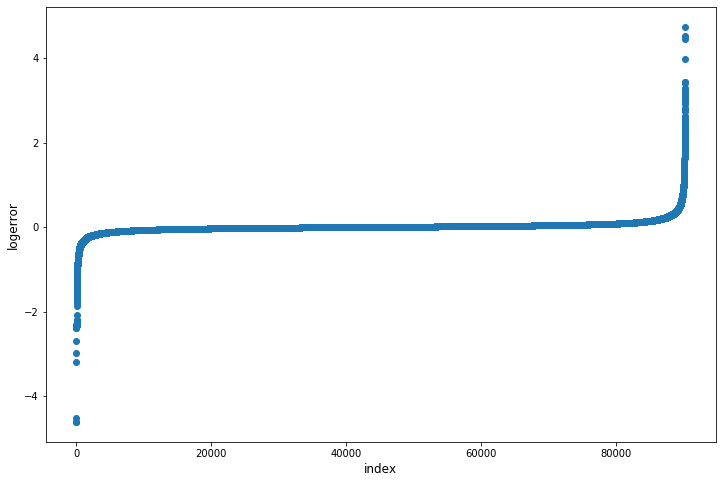

In [14]:
#plot the logerror
plt.figure(figsize=(12,8))
plt.scatter(range(train_data.shape[0]),np.sort(train_data.logerror.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('logerror',fontsize=12)
plt.show()

发现大部分在0附近，但同时存在许多outliers。

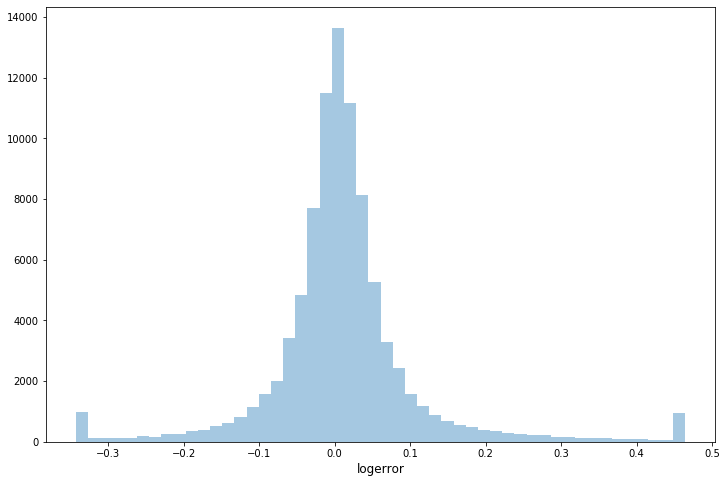

In [15]:
#delete the outliers
train_data_out=train_data.copy()
ulimit=np.percentile(train_data_out.logerror.values,99)
llimit=np.percentile(train_data_out.logerror.values,1)
train_data_out.loc[train_data_out['logerror']>ulimit,'logerror']=ulimit
train_data_out.loc[train_data_out['logerror']<llimit,'logerror']=llimit
#plot
plt.figure(figsize=(12,8))
sns.distplot(train_data_out.logerror.values,bins=50,kde=False)
plt.xlabel('logerror',fontsize=12)
plt.show()

可以看到logerror基本服从正态分布。为了方便观察zestimator的准确性，取logerror的绝对值来衡量其评估是否准确。

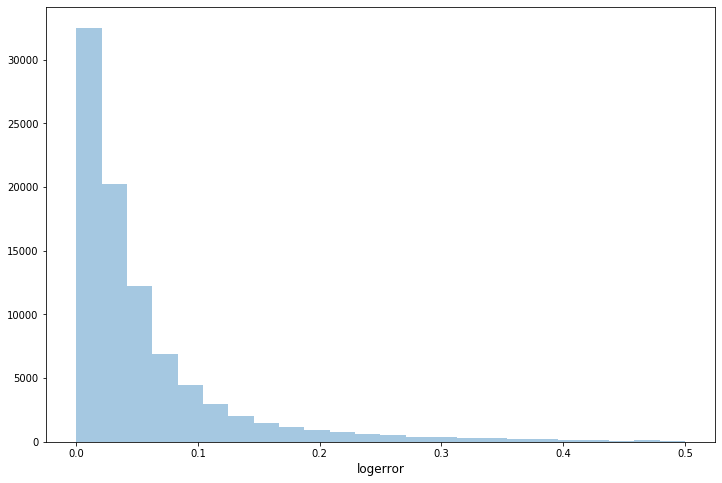

In [16]:
#absolute logerror
plt.figure(figsize=(12,8))
sns.distplot(abs(train_data.logerror.values),bins=np.linspace(0,0.5,25),kde=False)
plt.xlabel('logerror',fontsize=12)
plt.show()

现在来探索交易时间对logerror的影响

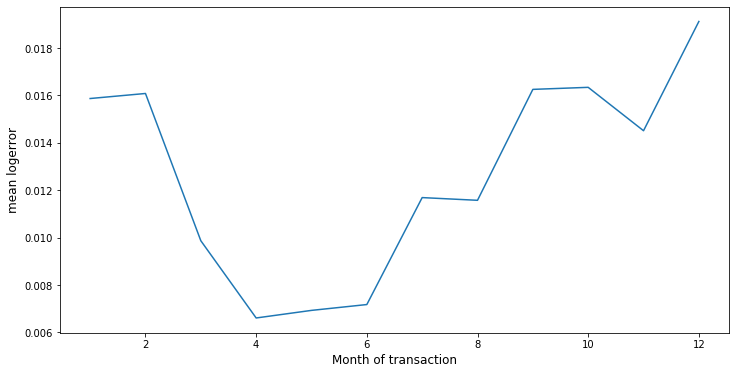

In [17]:
#extract the date 
train_data['transactiondate']=pd.to_datetime(train_data['transactiondate'])
train_data['transaction_month']=train_data['transactiondate'].dt.month
mean_logerror=train_data.groupby('transaction_month',as_index=False)['logerror'].mean()
mean_logerror=mean_logerror.rename(columns={'logerror':'mean_logerror'})

#plot
plt.figure(figsize=(12,6))
plt.plot(mean_logerror['transaction_month'],mean_logerror['mean_logerror'])
plt.xlabel('Month of transaction',fontsize=12)
plt.ylabel('mean logerror',fontsize=12)
plt.show()

可以发现在春季末夏季初zestimator的准确性更高，之后随着季节的推移，zestimator的准确率总体呈下降趋势。

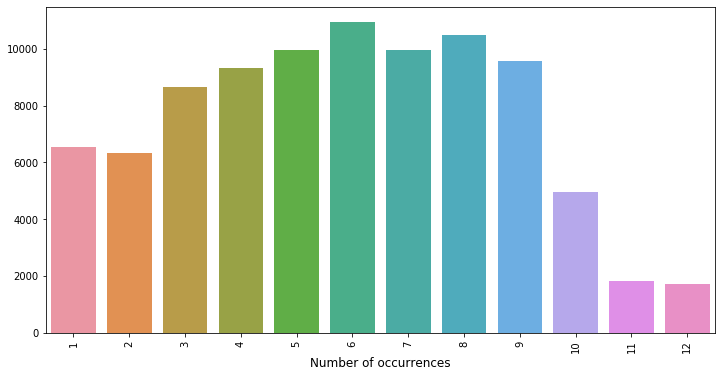

In [18]:
#calculate the transactions of every month
cnt_srs=train_data['transaction_month'].value_counts()

#plot
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index,cnt_srs.values)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction',fontsize=12)
plt.xlabel('Number of occurrences',fontsize=12)
plt.show()

结合上面两个图可以看到，在3、4、5、6、7、8月交易数较大的月份，zestimator的准确率都比较低。

In [19]:
#add the month to training data
train_data_merge['transaction_month']=train_data['transaction_month']

### 2.相关性分析

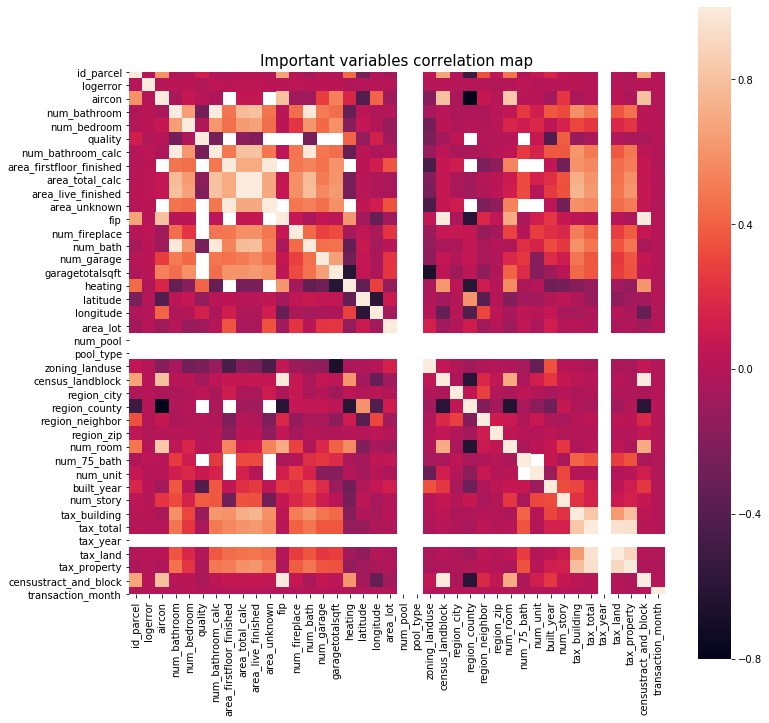

In [20]:
#calculate the correlations
corrmat=train_data_merge.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

可以看到各个特征与logerror的相关程度均比较低，现对特征进行大致分类，详细观察变量与logerror的相关性。

In [21]:
#set the lists
num=['logerror']
area=['logerror']
tax=['logerror']
#extract the columns
for n in train_data_merge.columns:
    if n.startswith('num_'):
        num.append(n)
    elif n.startswith('area_'):
        area.append(n)
    elif n.startswith('tax_'):
        tax.append(n)

#plot function
def corr_plot(x):
    num_corr=train_data_merge[x].corr()
    plt.figure(figsize=(12,12))
    sns.heatmap(num_corr,annot=True, vmax=1., square=True)
    plt.title("variables correlation map", fontsize=15)
    plt.show()     

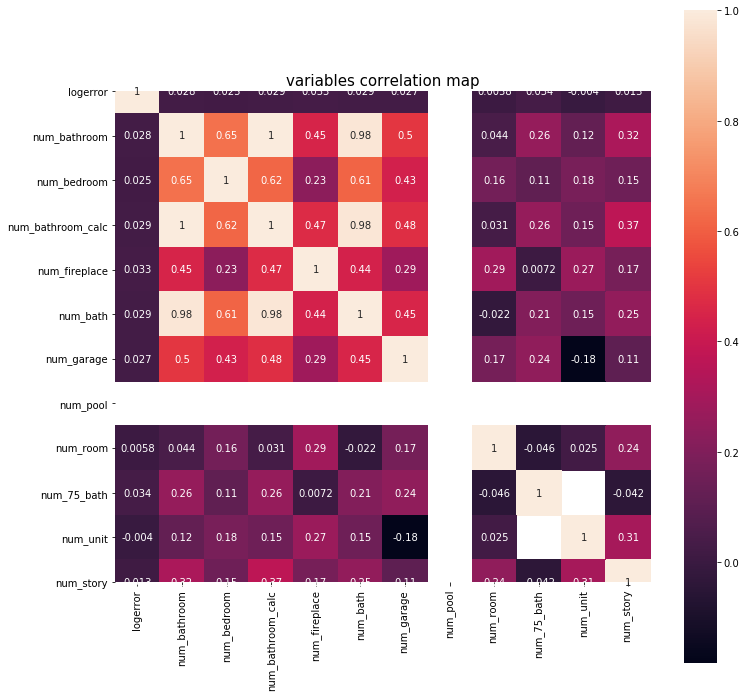

In [22]:
corr_plot(num)

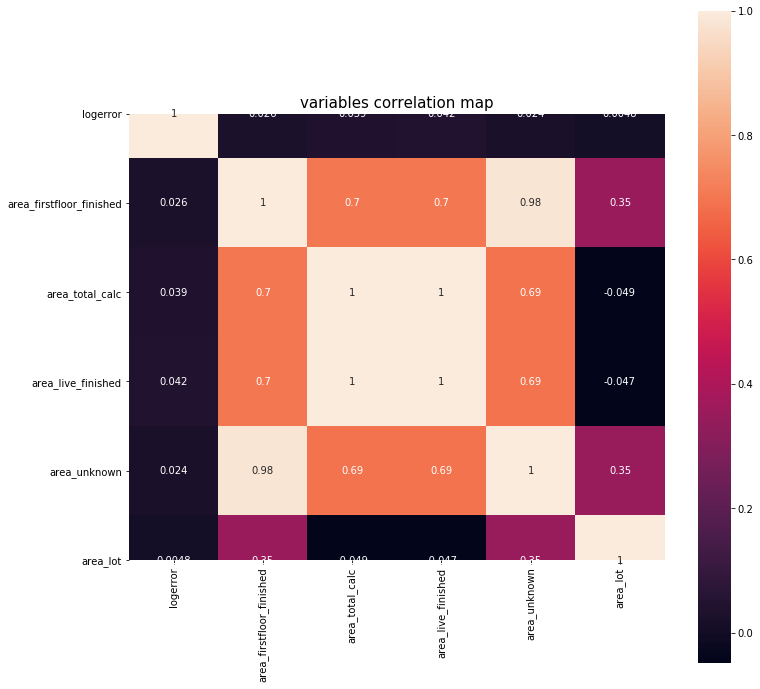

In [23]:
corr_plot(area)

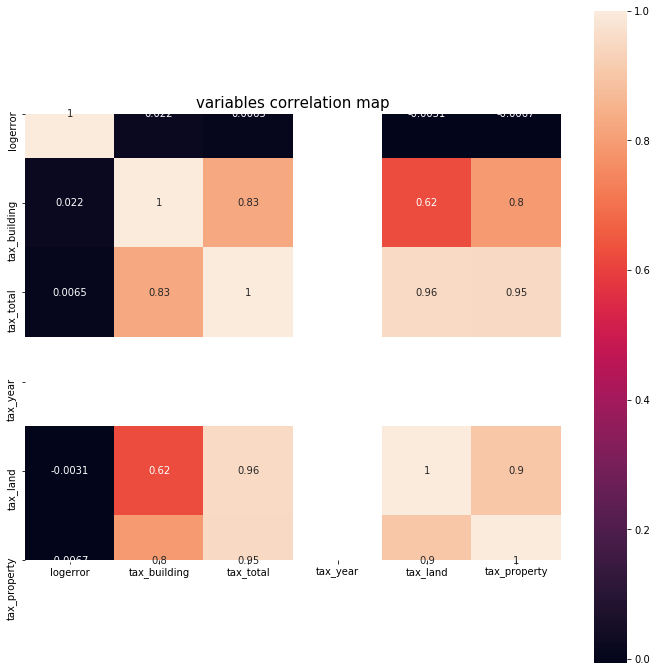

In [24]:
corr_plot(tax)

我们可以看到这些变量与logerror的相关程度都很低，这在一定程度上说明这些变量的影响不大会影响zestimate的评估结果。然而，我们仍然希望能发现一些特征，或者至少是一些特征值的范围，这些特征值仍然可以改进预测。

接下来对其他变量进行一些探索

D:\software\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\software\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Distribution of built_year')

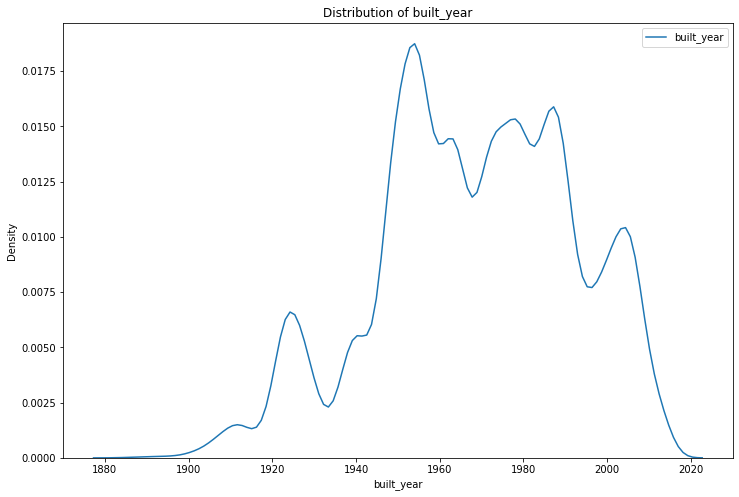

In [25]:
#查看built_year的分布情况
plt.figure(figsize=(12,8))
sns.kdeplot(train_data_merge['built_year'])
plt.xlabel('built_year')
plt.ylabel('Density')
plt.title('Distribution of built_year')

可以看到训练集中的大部分房屋建造于1950-1990年之间。

In [26]:
#logerror绝对值随build_year变化
train_data_merge['abs_logerror']=np.abs(train_data_merge['logerror'])
def bar_plot(variable):
    if variable=='built_year':
        plt.figure(figsize=(18,8))
        plt.xticks(rotation=90)
    else:
        plt.figure(figsize=(12,8))
    sns.barplot(x=variable,y='abs_logerror',data=train_data_merge)
    plt.xlabel(variable)
    plt.ylabel('abs_logerror')
    plt.show()

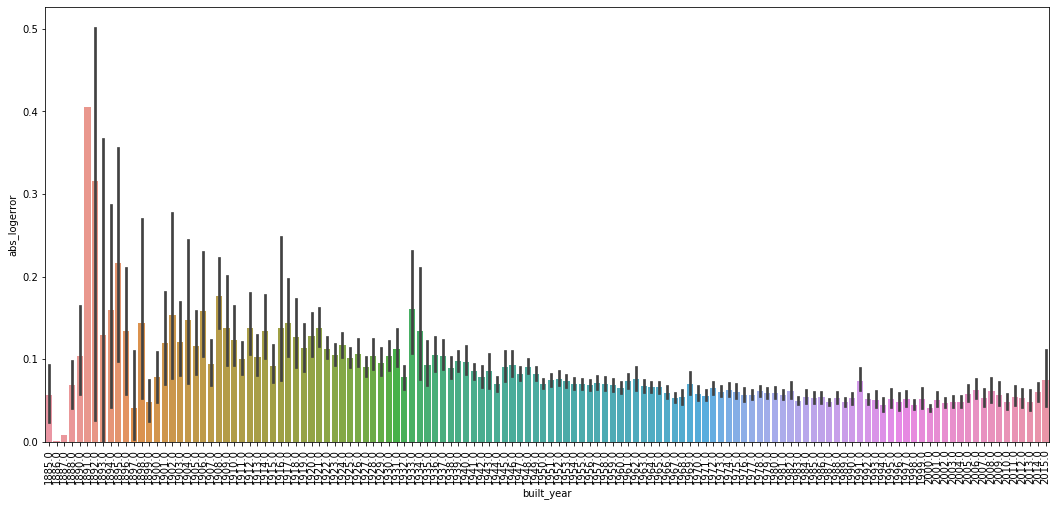

In [27]:
bar_plot('built_year')

可以发现相比于20世纪五十年代之后的房屋，zillow对年代久远的房屋价值的预测不准确。

现在根据logerror的准确程度对训练集进行分类，观察各变量在不同类型logerror下的分布情况

In [28]:
#cut the abs_logeroor
worst_fit=np.percentile(train_data_merge.abs_logerror.values,90)
typical_fit=np.percentile(train_data_merge.abs_logerror.values,50)
best_fit=np.percentile(train_data_merge.abs_logerror.values,10)
best_index=train_data_merge.loc[train_data_merge['abs_logerror']<best_fit,:].index
worst_index=train_data_merge.loc[train_data_merge['abs_logerror']>worst_fit,:].index
typical_index=train_data_merge.loc[abs(train_data_merge['abs_logerror']-typical_fit)<0.025,:].index

#plot function
def kde_plot(variable):
    plt.figure(figsize=(12,8))
    sns.kdeplot(train_data_merge.loc[best_index,variable],label='best_fit')
    sns.kdeplot(train_data_merge.loc[worst_index,variable],label='worst_fit')
    sns.kdeplot(train_data_merge.loc[typical_index,variable],label='typical_fit')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.title('Distribution of %s'% variable)

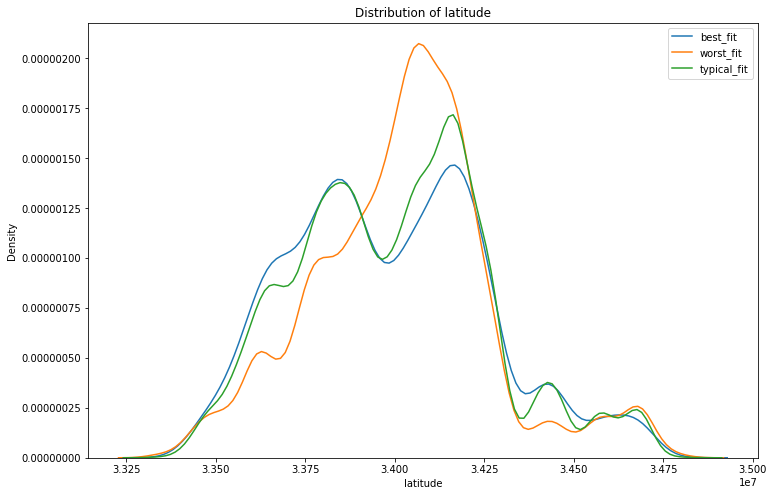

In [29]:
kde_plot('latitude')

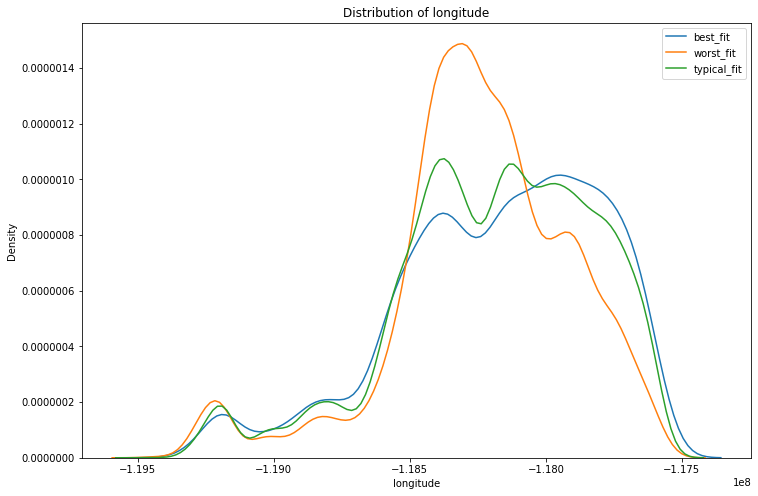

In [30]:
kde_plot('longitude')

结合上面两个图，可以看到经纬度在某一范围内，zesimator的预测准确度不高，存在区分度。

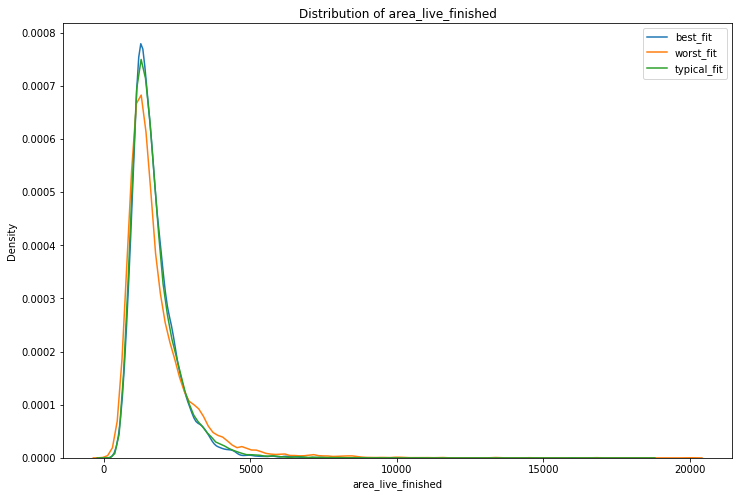

In [31]:
kde_plot('area_live_finished')

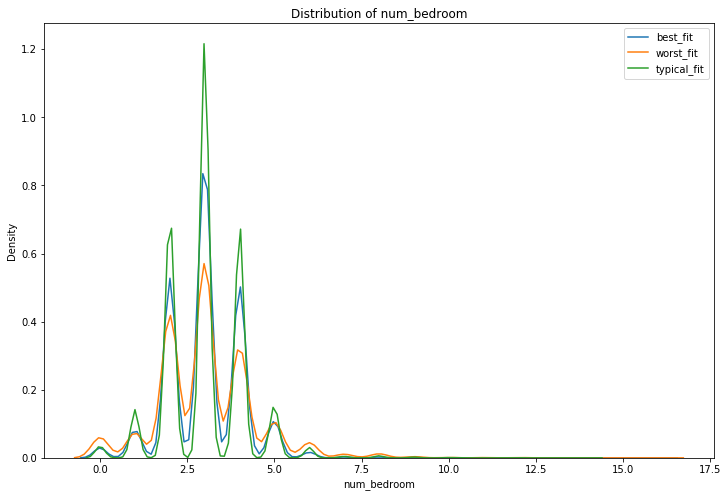

In [32]:
kde_plot('num_bedroom')

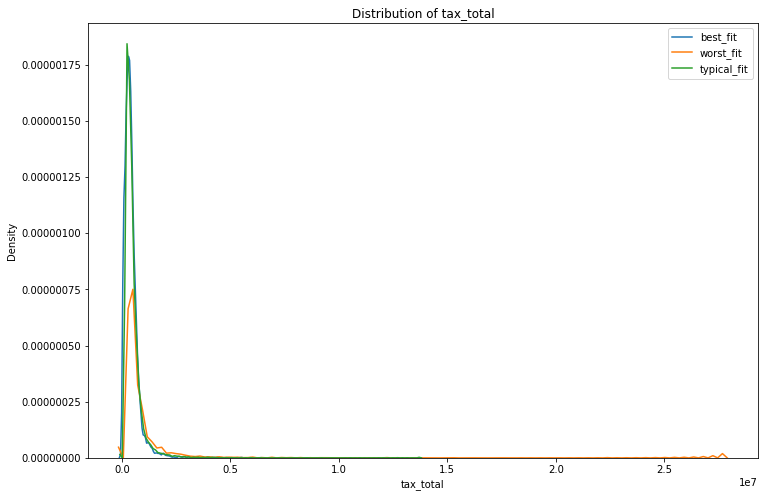

In [33]:
kde_plot('tax_total')

从上面几个图可以看到，随着各变量的变化，预测准确度abs_logerror区分并不明显，这从另一角度说明变量与logerror之间的相关程度不高。

In [34]:
#plot function
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp=train_data_merge[feature].value_counts()
    df1=pd.DataFrame({feature:temp.index,'Number of contracts':temp.values})
    
    #Calculate the percentage of target=1 per category value
    cat_perc=train_data_merge[[feature,'abs_logerror']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='abs_logerror',ascending=False,inplace=True)
    
    if (horizontal_layout):
        fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,6))
    else:
        fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,14))
        
    sns.set_color_codes('pastel')
    s=sns.barplot(ax=ax1,x=feature,y='Number of contracts',data=df1)
    if (label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s=sns.barplot(ax=ax2,x=feature,y='abs_logerror',order=cat_perc[feature],data=cat_perc)
    plt.ylabel('Percent of target with value 1 (%)',fontsize=10)
    plt.tick_params(axis='both',which='major',labelsize=10)
    
    plt.show()

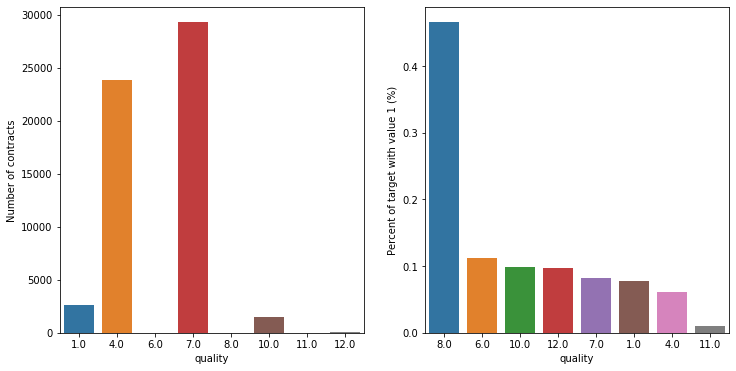

In [35]:
#房屋建造质量
plot_stats('quality')

大部分房屋建造质量的评分为4分和7分，zillow在这两种房屋上预测的对数误差在0.1以下。

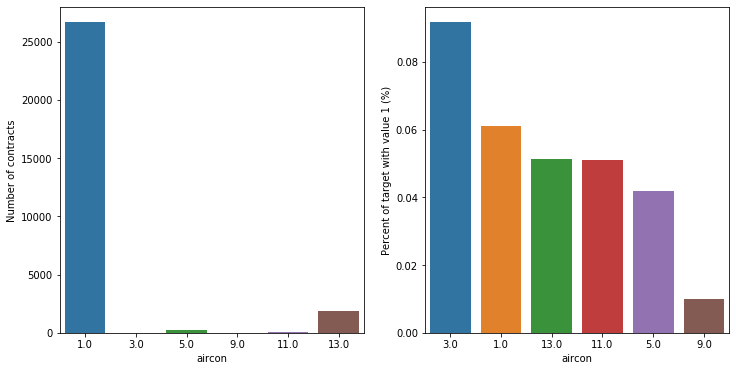

In [36]:
plot_stats('aircon')

结合官方文档，绝大部分房屋采用中央空调系统，zillow对此类房屋预测的对数误差约为0.06。

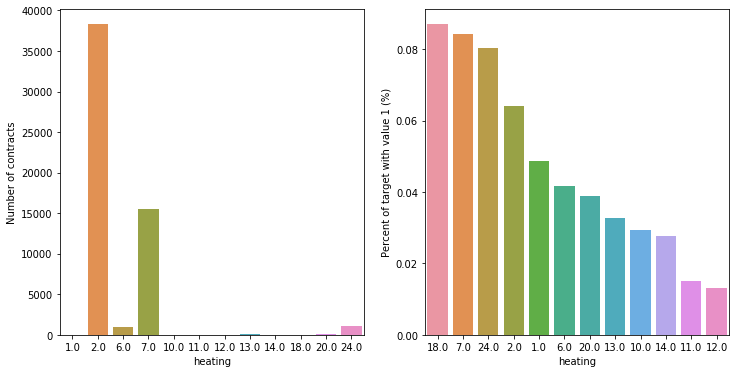

In [37]:
plot_stats('heating')

结合官方文档，超过35000个房屋采用中央空调供暖，约15000个房屋采用地板辐射方式采暖。zillow对使用地板辐射采暖的房屋进行价值预测的对数误差较高，约为0.08；采用中央空调采暖的房屋的对数误差较低，约为0.06。

## 四、特征工程

根据对业务的理解，从房产特征、税费、所属区域三个方面构造特征。

In [38]:
# convert to be categorical
cate_columns=['region_city','region_county','region_neighbor','zoning_landuse','censustract_and_block','census_landblock','region_zip','pool_type',
             'aircon','heating']
train_data_merge.loc[:,cate_columns]=train_data_merge.loc[:,cate_columns].astype('object')

In [39]:
#create new fatures


#copy
df_train=train_data_merge.copy()
#delete the abs_logerror
df_train.drop('abs_logerror',axis=1,inplace=True)

#life of property
df_train['num_built_age']=2020-df_train['built_year']
#error in calculation of the finished living area of home
df_train['rat_living_area_error']=1-df_train['area_total_calc']/df_train['area_live_finished']
#proportion of firstfloor in living area
df_train['rat_firstfloor_area']=df_train['area_firstfloor_finished']/df_train['area_live_finished']
#proportion of living area in lot
df_train['rat_living_area']=df_train['area_live_finished']/df_train['area_lot']
#average room size
df_train['avg_room_size']=df_train['area_live_finished']/df_train['num_room']

#length of time since unpaid taxes
df_train['num_tax_length']=2020-df_train['tax_year']

#number of properties in the city
city_count=df_train['region_city'].value_counts().to_dict()
df_train['num_city_count']=df_train['region_city'].map(city_count)
#number of properties in the county
county_count=df_train['region_county'].value_counts().to_dict()
df_train['num_county_count']=df_train['region_county'].map(county_count)

In [40]:
df_train

,id_parcel,logerror,date_transaction,aircon,num_bathroom,num_bedroom,quality,num_bathroom_calc,area_firstfloor_finished,area_total_calc,...,censustract_and_block,transaction_month,num_built_age,rat_living_area_error,rat_firstfloor_area,rat_living_area,avg_room_size,num_tax_length,num_city_count,num_county_count
0,11016594,0.0276,2016-01-01,1,2.0,3.0,4.0,2.0,NaN,1684.0,...,6.03711e+13,1,61.0,0.0,NaN,0.223698,inf,5.0,20559.0,58574
1,14366692,-0.1684,2016-01-01,NaN,3.5,4.0,NaN,3.5,NaN,2263.0,...,NaN,1,6.0,0.0,NaN,0.621191,inf,5.0,820.0,24505
2,12098116,-0.0040,2016-01-01,1,3.0,2.0,4.0,3.0,NaN,2217.0,...,6.03746e+13,1,80.0,0.0,NaN,0.194082,inf,5.0,1187.0,58574
3,12643413,0.0218,2016-01-02,1,2.0,2.0,4.0,2.0,NaN,839.0,...,6.0373e+13,1,33.0,0.0,NaN,0.011840,inf,5.0,20559.0,58574
4,14432541,-0.0050,2016-01-02,NaN,2.5,4.0,NaN,2.5,NaN,2283.0,...,6.05904e+13,1,39.0,0.0,NaN,0.380500,285.375,5.0,367.0,24505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,1,1.0,1.0,4.0,1.0,NaN,653.0,...,6.03713e+13,12,41.0,0.0,NaN,0.006971,inf,5.0,20559.0,58574
90271,12046695,0.0070,2016-12-30,NaN,3.0,3.0,4.0,3.0,NaN,2856.0,...,6.0373e+13,12,55.0,0.0,NaN,0.305683,inf,5.0,1052.0,58574
90272,12995401,-0.2679,2016-12-30,NaN,2.0,4.0,7.0,2.0,NaN,2617.0,...,6.03743e+13,12,96.0,NaN,NaN,NaN,NaN,5.0,289.0,58574
90273,11402105,0.0602,2016-12-30,NaN,2.0,2.0,4.0,2.0,NaN,1034.0,...,6.0376e+13,12,39.0,0.0,NaN,0.051615,inf,5.0,302.0,58574


## 五、建模预测

### 1.查看特征重要性

In [41]:
def model(train_data,encoding='le',n_folds=5):
    """数据准备"""
    #Extract the ids
    train_ids=train_data['id_parcel']

    
    #Extract the labels for training
    labels=train_data['logerror']
    
    #Remove the ids and target
    train_data=train_data.drop(['id_parcel','logerror','date_transaction','census_landblock','censustract_and_block'],axis=1)

    

    #Integer label encoding
    if encoding=='le':
        
        #create a label encoder
        label_encoder=LabelEncoder()
        
        #List for storing categorical indices
        cat_indices=[]
        
        #Iterate through each column
        for i,col in enumerate(train_data):
            if train_data[col].dtype=='object':
                #Map the categorical features to integers
                train_data[col]=label_encoder.fit_transform(np.array(train_data[col].astype(str)).reshape((-1,)))
                
                #record the categorical indices
                cat_indices.append(i)
        
        #Convert to float32
        train_data=train_data.astype('float32')
        
        
    #catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le' ")
    
    """输出训练集的shape"""
    print('training data shape:',train_data.shape)
    
    
    #Extract feature names
    feature_names=list(train_data.columns)
    
    #Convert to np arrays
    train_data=np.array(train_data)
    #create the Kfold object
    k_fold=KFold(n_splits=n_folds,shuffle=True,random_state=50)
        
    #Empty array for feature importances
    feature_importance_values=np.zeros(len(feature_names))
        
    #Empty array for out of fold validation predictions
    out_of_fold=np.zeros(train_data.shape[0])
        
    #Lists for recording validation and training scores
    valid_scores=[]
    train_scores=[]
    
    """建立模型"""
    #Iterate through each fold
    for train_indices,valid_indices in k_fold.split(train_data):
            
        #Training data for the fold
        train_features,train_labels=train_data[train_indices],labels[train_indices]
        #Validation data for the fold
        valid_features,valid_labels=train_data[valid_indices],labels[valid_indices]
            
        #Create the model
        model=lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.05,
                                 reg_alpha=0.1,reg_lambda=0.1,subsample=0.8,n_jobs=-1,random_state=50)
        
        #Train the model
        model.fit(train_features,train_labels,eval_metric='l2',eval_set=[(valid_features,valid_labels),(train_features,train_labels)],
                 eval_names=['valid','train'],categorical_feature=cat_indices,
                  early_stopping_rounds=100,verbose=200)
        
        #Record the best iteration
        best_iteration=model.best_iteration_
        
        #Record the feature importances
        feature_importance_values+=model.feature_importances_/k_fold.n_splits
               
        #record the out of fold predictions
        out_of_fold[valid_indices]=model.predict(valid_features,num_iteration=best_iteration)
        
        #record the best score
        valid_score=model.best_score_['valid']['l2']
        train_score=model.best_score_['train']['l2']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        #clean up memory
        gc.enable()
        del train_features,valid_features
        gc.collect()

    """整合要输出的结果"""
    #Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_l2 = mean_squared_error(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_l2)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return model,feature_importances, metrics

In [42]:
model,feature_importances, metrics=model(df_train,encoding='le')

training data shape: (90275, 46)


D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	train's l2: 0.0249254	valid's l2: 0.0242828


D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 0.023613	valid's l2: 0.0240185


D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	train's l2: 0.022778	valid's l2: 0.0261021


D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	train's l2: 0.0219556	valid's l2: 0.0276772


D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	train's l2: 0.0238747	valid's l2: 0.0258013


In [43]:
print(metrics)

      fold     train     valid
0        0  0.024925  0.024283
1        1  0.023613  0.024018
2        2  0.022778  0.026102
3        3  0.021956  0.027677
4        4  0.023875  0.025801
5  overall  0.023429  0.025576


In [44]:
#通过lgb自带函数查看特征的重要性
def plot_feature_importances(df):
    
    #Sort features according to importance
    df=df.sort_values('importance',ascending=False).reset_index()
    
    #Normalize the feature importances to add up to one
    df['importance_normalized']=df['importance']/df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10,6))
    ax=plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),df['importance_normalized'].head(15),align='center',edgecolor='k')
    
    #set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #plot labeling
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances')
    plt.show()

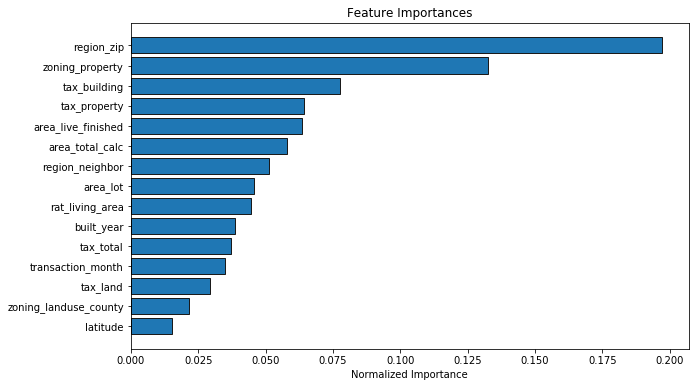

In [45]:
plot_feature_importances(feature_importances)

### 2.测试集预测
现在导入2016年的测试数据，对其进行预测

In [46]:
#导入测试数据，对测试集数据做一些处理（与训练集处理方式基本相同）
sample=pd.read_csv(r'E:\machine learning\zillow-prize-1\sample_submission.csv')
sample=sample.rename(columns={'ParcelId':'parcelid'})
test_data=sample.merge(data_prop, on='parcelid', how='left')

#testing
test_data=test_data.rename(columns={'parcelid':'id_parcel',
                           'transactiondate':'date_transaction',
                           'transaction_month':'month_transaction',
                           'airconditioningtypeid':'aircon',
                           'bathroomcnt':'num_bathroom',
                           'bedroomcnt':'num_bedroom',
                           'buildingqualitytypeid':'quality',
                           'calculatedbathnbr':'num_bathroom_calc',
                           'calculatedfinishedsquarefeet':'area_total_calc',
                           'finishedsquarefeet12':'area_live_finished',
                           'fips':'fip',
                           'fullbathcnt':'num_bath',
                           'garagecarcnt':'num_garage',
                           'heatingorsystemtypeid':'heating',
                           'lotsizesquarefeet':'area_lot',
                           'propertycountylandusecode':'zoning_landuse_county',
                           'propertylandusetypeid':'zoning_landuse',
                           'propertyzoningdesc':'zoning_property',
                           'rawcensustractandblock':'census_landblock',
                           'regionidcity':'region_city',
                           'regionidcounty':'region_county',
                           'regionidneighborhood':'region_neighbor',
                           'regionidzip':'region_zip',
                           'roomcnt':'num_room',
                           'unitcnt':'num_unit',
                           'yearbuilt':'built_year',
                           'structuretaxvaluedollarcnt':'tax_building',
                           'taxvaluedollarcnt':'tax_total',
                           'assessmentyear':'tax_year',
                           'landtaxvaluedollarcnt':'tax_land',
                           'taxamount':'tax_property',
                           'censustractandblock':'censustract_and_block',
                           'finishedsquarefeet50':'area_unknown',
                           'finishedfloor1squarefeet':'area_firstfloor_finished',
                           'fireplacecnt':'num_fireplace',
                           'threequarterbathnbr':'num_75_bath',
                           'pooltypeid7':'pool_type',
                           'poolcnt':'num_pool',
                           'numberofstories':'num_story'
                          })

test_data.loc[:,cate_columns]=test_data.loc[:,cate_columns].astype('object')

#life of property
test_data['num_built_age']=2020-test_data['built_year']
#error in calculation of the finished living area of home
test_data['rat_living_area_error']=1-test_data['area_total_calc']/test_data['area_live_finished']
#proportion of firstfloor in living area
test_data['rat_firstfloor_area']=test_data['area_firstfloor_finished']/test_data['area_live_finished']
#proportion of living area in lot
test_data['rat_living_area']=test_data['area_live_finished']/test_data['area_lot']
#average room size
test_data['avg_room_size']=test_data['area_live_finished']/test_data['num_room']


#length of time since unpaid taxes
test_data['num_tax_length']=2020-test_data['tax_year']


#number of properties in the city
city_count_1=test_data['region_city'].value_counts().to_dict()
test_data['num_city_count']=test_data['region_city'].map(city_count_1)
#number of properties in the county
county_count_1=test_data['region_county'].value_counts().to_dict()
test_data['num_county_count']=test_data['region_county'].map(county_count_1)

#clean the columns
x_train=df_train.drop(['date_transaction', 'logerror', 'transaction_month'],axis=1)
col_train=list(x_train.columns)
test_data=test_data[col_train]

In [47]:
# get the date information
def get_features(df):
    df['date_transaction']=pd.to_datetime(df['date_transaction'],format='%Y-%m-%d')
    df['transaction_month']=df['date_transaction'].dt.month
    df=df.drop(['date_transaction'],axis=1)
    return np.array(df)

In [48]:
test_data.shape

(2985217, 48)

In [49]:
x_train=df_train.drop(['id_parcel','logerror','date_transaction','census_landblock','censustract_and_block'],axis=1)
y_train=df_train['logerror']

def encoding(df):
    #create a label encoder
    label_encoder=LabelEncoder()
        
    #List for storing categorical indices
    cat_indices=[]
        
    #Iterate through each column
    for i,col in enumerate(df):
        if df[col].dtype=='object':
            #Map the categorical features to integers
            df[col]=label_encoder.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))
                
            #record the categorical indices
            cat_indices.append(i)
        
    #Convert to float32
    df=df.astype('float32')
    return df,cat_indices

#model training
x_train,cat_indices=encoding(x_train)
model.fit(x_train,y_train,eval_metric='l2',categorical_feature=cat_indices,verbose=200)

D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=50, reg_alpha=0.1, reg_lambda=0.1, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [50]:
#prepate the testing data
best_iteration=model.best_iteration_
x_test=test_data.drop(['id_parcel','census_landblock','censustract_and_block'],axis=1)
x_test,cat=encoding(x_test)
#Make predictions
pred_date=['2016-10-01','2016-11-01','2016-12-01']
pred_month=['2016-10','2016-11','2016-12']
test_predictions={}
for i in range(len(pred_date)):
    x_test['date_transaction']=pred_date[i]
    test_predictions[pred_month[i]]=model.predict(get_features(x_test),num_iteration=best_iteration)

In [74]:
#output the data in 2016
submission_2016=pd.DataFrame(test_predictions)
submission_2016.insert(0,'parcelid',test_data['id_parcel'])

In [67]:
#导入2017年的数据
train_2017=pd.read_csv(r'E:\machine learning\zillow-prize-1\train_2017.csv')

In [68]:
train_2017=train_2017.merge(data_prop,on='parcelid',how='left')

In [69]:
#testing
train_2017=train_2017.rename(columns={'parcelid':'id_parcel',
                           'transactiondate':'date_transaction',
                           'transaction_month':'month_transaction',
                           'airconditioningtypeid':'aircon',
                           'bathroomcnt':'num_bathroom',
                           'bedroomcnt':'num_bedroom',
                           'buildingqualitytypeid':'quality',
                           'calculatedbathnbr':'num_bathroom_calc',
                           'calculatedfinishedsquarefeet':'area_total_calc',
                           'finishedsquarefeet12':'area_live_finished',
                           'fips':'fip',
                           'fullbathcnt':'num_bath',
                           'garagecarcnt':'num_garage',
                           'heatingorsystemtypeid':'heating',
                           'lotsizesquarefeet':'area_lot',
                           'propertycountylandusecode':'zoning_landuse_county',
                           'propertylandusetypeid':'zoning_landuse',
                           'propertyzoningdesc':'zoning_property',
                           'rawcensustractandblock':'census_landblock',
                           'regionidcity':'region_city',
                           'regionidcounty':'region_county',
                           'regionidneighborhood':'region_neighbor',
                           'regionidzip':'region_zip',
                           'roomcnt':'num_room',
                           'unitcnt':'num_unit',
                           'yearbuilt':'built_year',
                           'structuretaxvaluedollarcnt':'tax_building',
                           'taxvaluedollarcnt':'tax_total',
                           'assessmentyear':'tax_year',
                           'landtaxvaluedollarcnt':'tax_land',
                           'taxamount':'tax_property',
                           'censustractandblock':'censustract_and_block',
                           'finishedsquarefeet50':'area_unknown',
                           'finishedfloor1squarefeet':'area_firstfloor_finished',
                           'fireplacecnt':'num_fireplace',
                           'threequarterbathnbr':'num_75_bath',
                           'pooltypeid7':'pool_type',
                           'poolcnt':'num_pool',
                           'numberofstories':'num_story'
                          })

train_2017.loc[:,cate_columns]=train_2017.loc[:,cate_columns].astype('object')

#life of property
train_2017['num_built_age']=2020-train_2017['built_year']
#error in calculation of the finished living area of home
train_2017['rat_living_area_error']=1-train_2017['area_total_calc']/train_2017['area_live_finished']
#proportion of firstfloor in living area
train_2017['rat_firstfloor_area']=train_2017['area_firstfloor_finished']/train_2017['area_live_finished']
#proportion of living area in lot
train_2017['rat_living_area']=train_2017['area_live_finished']/train_2017['area_lot']
#average room size
train_2017['avg_room_size']=train_2017['area_live_finished']/train_2017['num_room']


#length of time since unpaid taxes
train_2017['num_tax_length']=2020-train_2017['tax_year']


#number of properties in the city
city_count_2=train_2017['region_city'].value_counts().to_dict()
train_2017['num_city_count']=train_2017['region_city'].map(city_count_2)
#number of properties in the county
county_count_2=train_2017['region_county'].value_counts().to_dict()
train_2017['num_county_count']=train_2017['region_county'].map(county_count_2)


x_train_2017=train_2017.drop(['id_parcel','logerror','census_landblock','censustract_and_block'],axis=1)
y_train_2017=train_2017['logerror']

In [71]:
#clean the columns
x_train_2017['date_transaction']=pd.to_datetime(x_train_2017['date_transaction'],format='%Y-%m-%d')
x_train_2017['transaction_month']=x_train_2017['date_transaction'].dt.month
col_train_2017=list(x_train.columns)
x_train_2017=x_train_2017[col_train_2017]
#model training
x_train_2017,cat_indices_2017=encoding(x_train_2017)
model.fit(x_train_2017,y_train_2017,eval_metric='l2',categorical_feature=cat_indices,verbose=200)

D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=50, reg_alpha=0.1, reg_lambda=0.1, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [79]:
#prepate the testing data
best_iteration_2017=model.best_iteration_
x_test_2017=test_data.drop(['id_parcel','census_landblock','censustract_and_block'],axis=1)
x_test_2017,cat=encoding(x_test_2017)
#Make predictions
pred_date_2017=['2017-10-01','2017-11-01','2017-12-01']
pred_month_2017=['2017-10','2017-11','2017-12']
test_predictions_2017={}
for i in range(len(pred_date_2017)):
    x_test_2017['date_transaction']=pred_date_2017[i]
    test_predictions_2017[pred_month_2017[i]]=model.predict(get_features(x_test_2017),num_iteration=best_iteration_2017)

In [80]:
#output the file
submission_2017=pd.DataFrame(test_predictions_2017)
submission_2017.insert(0,'parcelid',test_data['id_parcel'])

In [88]:
submission=pd.merge(submission_2016,submission_2017,on='parcelid')
submission=submission.rename(columns={'2016-10':'201610','2016-11':'201611','2016-12':'201612','2017-10':'201710','2017-11':'201711','2017-12':'201712'})

In [90]:
submission.to_csv('E:/submission_total.csv',index=0)

## 六、结论
     

1. 经过对2016年数据的分析，得到以下结论：
   - 房产所属地区及房产所占土地的使用情况是影响zestimator评估结果的主要因素,zestimator的优化应在这两个方面下功夫。
   + 房产的卧室数量，空调系统类型等房产自身指标对zestimator评估结果影响不大，表明zestimator在这些特征上已经建立了良好的评估体系。
2. 利用辅助训练集后，运用lightgbm算法进行建模预测，在测试集上的得分为0.0674。